## Inside Edinburgh Airbnb

### Inspiration and aim of this project

The Airbnb model, which connects travelers with individuals offering accommodations in their homes or properties, offers several advantages. It provides a wide range of lodging options, often at lower prices than traditional hotels, and allows hosts to earn income from their unused space. It fosters a sense of community and cultural exchange, enabling travelers to immerse themselves in local cultures. 

However, this model has its downsides, including concerns about safety and security, potential neighborhood disturbances caused by irresponsible guests, and issues related to housing shortages and the displacement of long-term residents in popular tourist destinations. Additionally, regulatory and tax compliance challenges have been a source of controversy in many regions, and some critics argue that Airbnb can contribute to rising rental costs and reduced housing availability in certain markets.

[Inside Airbnb](http://insideairbnb.com/about/) is a mission driven project that provides data and advocacy about Airbnb's impact on residential communities. I reviewed the available data and noted that Edinburgh, Scotland (a city I spent 14 years in) is included which inspired me to perform a data dive. I decided I would try to enrich my analysis by making use of spatial data that I used in another [recent project](https://github.com/Stephen137/Scottish-Index-of-Multiple-Deprivation) on the Scottish Index of Multiple Deprivation (SIMD).

My overall aim is to create a choropleth map of the area covered by the Edinburgh Airbnb listings to reveal the density of listings in each data zone. I hope to achieve this by deconstructing the problem into the following steps :


- `Step 1:` Establish which datazone each of the Airbnb listings falls within by performing a spatial join

- `Step 2:` Calculate the number of property listings within each data zone

- `Step 3:` Calculate the property listing density per data zone using the calculation above and the area metadata that is included with the data zone shape file

- `Step 4:` Plot a choropleth map with appropriate colour ramp to provide insights regarding the density of Airbnb properties across Edinburgh

### Import the required packages

In [1]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load in our data

#### Spatial Data

In [2]:
datazones = gpd.read_file('data/shapefiles/sc_dz_11.shp')
print(f"Number of rows: {len(datazones)}")

Number of rows: 6976


In [3]:
datazones.head()

,DataZone,Name,TotPop2011,ResPop2011,HHCnt2011,StdAreaHa,StdAreaKm2,Shape_Leng,Shape_Area,geometry
0,S01006506,Culter - 01,872,852,424,438.880218,4.388801,11801.872345,4.388802e+06,"POLYGON ((-2.27748 57.09527, -2.27644 57.09521..."
1,S01006507,Culter - 02,836,836,364,22.349739,0.223498,2900.406362,2.217468e+05,"POLYGON ((-2.27354 57.10449, -2.27333 57.10449..."
2,S01006508,Culter - 03,643,643,340,27.019476,0.270194,3468.761949,2.701948e+05,"POLYGON ((-2.27443 57.10171, -2.27237 57.10046..."
3,S01006509,Culter - 04,580,580,274,9.625426,0.096254,1647.461389,9.625426e+04,"POLYGON ((-2.26611 57.10133, -2.26599 57.10092..."
4,S01006510,Culter - 05,644,577,256,18.007657,0.180076,3026.111412,1.800766e+05,"POLYGON ((-2.26013 57.10160, -2.26050 57.10134..."


So, as you can our `datazones` dataset contains `6,976` rows which represent "datazones" as defined and included as part of the Scottish Government Index of Multiple Deprivation (SIMD) and we have some basic metadata associated with these datazones, in particular the area of each zone which we will be using to calculate the density of Airbnb property listings.

In [4]:
type(datazones)

geopandas.geodataframe.GeoDataFrame

Our `datazones` dataset has been loaded from a shapefile using geopandas and is a `GeoDataFrame` - we have a `geometry` column which includes the Polygon geomtery of each of the 6,976 data zones. We can visualize in just one line of code :

<AxesSubplot: >

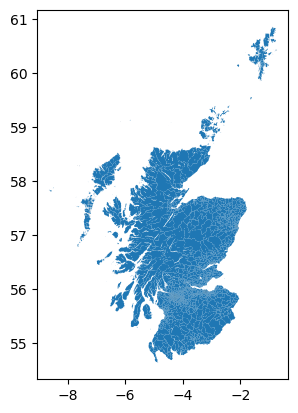

In [5]:
datazones.plot()

#### Non-spatial data

In [6]:
### create a non-spatial DataFrame from the listings data
edin_listings = pd.read_csv('data/edinburgh_airbnb_listings.csv')
print(f"Number of rows: {len(edin_listings)}")

Number of rows: 8044


In [7]:
edin_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,15420,Rental unit in Edinburgh · ★4.97 · 1 bedroom ·...,60423,Charlotte,NaN,"Old Town, Princes Street and Leith Street",55.957590,-3.188050,Entire home/apt,130,3,511,2023-09-03,3.32,1,16,79,NaN
1,24288,Loft in Edinburgh · ★4.62 · 2 bedrooms · 2 bed...,46498,Gordon,NaN,"Canongate, Southside and Dumbiedykes",55.944983,-3.185293,Entire home/apt,91,3,286,2023-07-24,1.81,1,42,55,NaN
2,48645,Condo in Edinburgh · ★4.86 · 1 bedroom · 2 bed...,221474,Mark,NaN,"Canongate, Southside and Dumbiedykes",55.950720,-3.183050,Private room,129,2,979,2023-09-08,6.37,1,69,68,NaN
3,51505,Rental unit in Edinburgh · ★4.76 · 2 bedrooms ...,236828,Francois,NaN,New Town West,55.954800,-3.196410,Entire home/apt,170,4,51,2023-08-23,0.33,14,2,32,NaN
4,54188,Boat in Edinburgh · ★4.61 · 3 bedrooms · 2 bed...,253850,Natalie,NaN,Dalry and Fountainbridge,55.942170,-3.208630,Entire home/apt,225,1,43,2022-07-03,0.32,3,175,0,NaN


So we have 8044 rows which represent Edinburgh Airbnb listings as at 11 September 2023. The data was sourced from [Inside Airbnb](http://insideairbnb.com/get-the-data).

In [8]:
type(edin_listings)

pandas.core.frame.DataFrame

### Convert the `pandas.DataFrame` into a `geopandas.GeoDataFrame`

Although our Airbnb listings dataset has a `longitude` and a `latitude` column this is not enough for it to qualify as a GeoDataFrame. However we can make use of this information to create a `geometry` column.

We want to create a `shapely.geometry.Point` *for each row*, based on the columns `longitude` and `latitude`.
There are different approaches to this task. One such method is the [`apply()` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) of the data frame, together with a *lambda function*.

In [9]:
from shapely.geometry import Point

# Create a column of empty Point objects
edin_listings['point_geometry'] = [Point() for _ in range(len(edin_listings))]

# Use a lambda function to create Point objects and assign them to the 'point_geometry' column
edin_listings['point_geometry'] = edin_listings.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

edin_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,point_geometry
0,15420,Rental unit in Edinburgh · ★4.97 · 1 bedroom ·...,60423,Charlotte,NaN,"Old Town, Princes Street and Leith Street",55.957590,-3.188050,Entire home/apt,130,3,511,2023-09-03,3.32,1,16,79,NaN,POINT (-3.18805 55.95759)
1,24288,Loft in Edinburgh · ★4.62 · 2 bedrooms · 2 bed...,46498,Gordon,NaN,"Canongate, Southside and Dumbiedykes",55.944983,-3.185293,Entire home/apt,91,3,286,2023-07-24,1.81,1,42,55,NaN,POINT (-3.185293348616568 55.94498320836646)
2,48645,Condo in Edinburgh · ★4.86 · 1 bedroom · 2 bed...,221474,Mark,NaN,"Canongate, Southside and Dumbiedykes",55.950720,-3.183050,Private room,129,2,979,2023-09-08,6.37,1,69,68,NaN,POINT (-3.18305 55.95072)
3,51505,Rental unit in Edinburgh · ★4.76 · 2 bedrooms ...,236828,Francois,NaN,New Town West,55.954800,-3.196410,Entire home/apt,170,4,51,2023-08-23,0.33,14,2,32,NaN,POINT (-3.19641 55.9548)
4,54188,Boat in Edinburgh · ★4.61 · 3 bedrooms · 2 bed...,253850,Natalie,NaN,Dalry and Fountainbridge,55.942170,-3.208630,Entire home/apt,225,1,43,2022-07-03,0.32,3,175,0,NaN,POINT (-3.20863 55.94217)


In [10]:
# explicitly specify the geometry column and the coordinate system
edin_listings = gpd.GeoDataFrame(edin_listings, geometry=edin_listings['point_geometry'], crs="WGS84")

In [11]:
type(edin_listings)

geopandas.geodataframe.GeoDataFrame

In [12]:
edin_listings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
edin_listings

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,point_geometry,geometry
0,15420,Rental unit in Edinburgh · ★4.97 · 1 bedroom ·...,60423,Charlotte,NaN,"Old Town, Princes Street and Leith Street",55.957590,-3.188050,Entire home/apt,130,3,511,2023-09-03,3.32,1,16,79,NaN,POINT (-3.18805 55.95759),POINT (-3.18805 55.95759)
1,24288,Loft in Edinburgh · ★4.62 · 2 bedrooms · 2 bed...,46498,Gordon,NaN,"Canongate, Southside and Dumbiedykes",55.944983,-3.185293,Entire home/apt,91,3,286,2023-07-24,1.81,1,42,55,NaN,POINT (-3.185293348616568 55.94498320836646),POINT (-3.18529 55.94498)
2,48645,Condo in Edinburgh · ★4.86 · 1 bedroom · 2 bed...,221474,Mark,NaN,"Canongate, Southside and Dumbiedykes",55.950720,-3.183050,Private room,129,2,979,2023-09-08,6.37,1,69,68,NaN,POINT (-3.18305 55.95072),POINT (-3.18305 55.95072)
3,51505,Rental unit in Edinburgh · ★4.76 · 2 bedrooms ...,236828,Francois,NaN,New Town West,55.954800,-3.196410,Entire home/apt,170,4,51,2023-08-23,0.33,14,2,32,NaN,POINT (-3.19641 55.9548),POINT (-3.19641 55.95480)
4,54188,Boat in Edinburgh · ★4.61 · 3 bedrooms · 2 bed...,253850,Natalie,NaN,Dalry and Fountainbridge,55.942170,-3.208630,Entire home/apt,225,1,43,2022-07-03,0.32,3,175,0,NaN,POINT (-3.20863 55.94217),POINT (-3.20863 55.94217)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8039,974513574116367354,Rental unit in Leith · ★New · 1 bedroom · 2 be...,131677538,Conor,NaN,Western Harbour and Leith Docks,55.986759,-3.188275,Private room,60,2,0,NaN,NaN,1,255,0,NaN,POINT (-3.1882747601883032 55.98675908383569),POINT (-3.18827 55.98676)
8040,974540296775384595,Rental unit in Edinburgh · ★New · 4 bedrooms ·...,146730114,Adam,NaN,Newington and Dalkeith Road,55.939714,-3.177628,Entire home/apt,399,2,0,NaN,NaN,9,258,0,NaN,POINT (-3.1776279 55.9397141),POINT (-3.17763 55.93971)
8041,975083364733576599,Rental unit in Edinburgh · ★New · 3 bedrooms ·...,238856343,Hany,NaN,Hillside and Calton Hill,55.959688,-3.176968,Entire home/apt,268,2,0,NaN,NaN,20,134,0,NaN,POINT (-3.176967726675298 55.959687801369945),POINT (-3.17697 55.95969)
8042,976567080851790966,Rental unit in Edinburgh · ★New · 1 bedroom · ...,18970049,Darcy,NaN,Moredun and Craigour,55.917985,-3.140077,Private room,56,1,0,NaN,NaN,2,207,0,NaN,POINT (-3.1400765961073613 55.91798460572752),POINT (-3.14008 55.91798)


### Step 1 - Performing a spatial join

We have a Point geometry for each of the property listings. We have a Polygon geometry for each of the data zones. We are now ready to join our GeoDataFrames.

In [14]:
airbnb_datazones = edin_listings.sjoin(datazones, how="left", predicate="within")

In [15]:
airbnb_datazones.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,index_right,DataZone,Name,TotPop2011,ResPop2011,HHCnt2011,StdAreaHa,StdAreaKm2,Shape_Leng,Shape_Area
0,15420,Rental unit in Edinburgh · ★4.97 · 1 bedroom ·...,60423,Charlotte,NaN,"Old Town, Princes Street and Leith Street",55.957590,-3.188050,Entire home/apt,130,...,2170,S01008676,"Old Town, Princes Street and Leith Street - 03",779,690,338,29.476317,0.294764,4133.369517,294763.155287
1,24288,Loft in Edinburgh · ★4.62 · 2 bedrooms · 2 bed...,46498,Gordon,NaN,"Canongate, Southside and Dumbiedykes",55.944983,-3.185293,Entire home/apt,91,...,2174,S01008680,"Canongate, Southside and Dumbiedykes - 01",631,597,326,5.128574,0.051285,1473.321749,51285.748615
2,48645,Condo in Edinburgh · ★4.86 · 1 bedroom · 2 bed...,221474,Mark,NaN,"Canongate, Southside and Dumbiedykes",55.950720,-3.183050,Private room,129,...,2179,S01008685,"Canongate, Southside and Dumbiedykes - 06",1025,777,489,17.121499,0.171215,2976.316012,171214.990188
3,51505,Rental unit in Edinburgh · ★4.76 · 2 bedrooms ...,236828,Francois,NaN,New Town West,55.954800,-3.196410,Entire home/apt,170,...,2343,S01008849,New Town West - 01,727,727,396,20.245548,0.202455,3294.418369,202455.476170
4,54188,Boat in Edinburgh · ★4.61 · 3 bedrooms · 2 bed...,253850,Natalie,NaN,Dalry and Fountainbridge,55.942170,-3.208630,Entire home/apt,225,...,2145,S01008651,Dalry and Fountainbridge - 01,965,686,497,16.718419,0.167184,3153.946787,167184.197335


### Step 2: Calculate the number of property listings within each data zone

We can use `.groupby` to group the number of properties in each data zone :

In [16]:
# group by DataZone and count # airbnb listings
count_listings = airbnb_datazones.groupby(['DataZone', 'Name', 'StdAreaKm2']).size().reset_index(name='Airbnb_Count')
count_listings.sort_values(by='Airbnb_Count',ascending=False)

,DataZone,Name,StdAreaKm2,Airbnb_Count
241,S01008677,"Old Town, Princes Street and Leith Street - 04",0.438908,218
429,S01008868,Deans Village - 01,0.284072,191
239,S01008675,"Old Town, Princes Street and Leith Street - 02",0.200589,159
410,S01008849,New Town West - 01,0.202455,133
240,S01008676,"Old Town, Princes Street and Leith Street - 03",0.294764,121
...,...,...,...,...
103,S01008533,Comiston and Swanston - 01,0.137717,1
278,S01008715,"Bingham, Magdalene and The Christians - 04",0.264941,1
533,S01008978,Carrick Knowe - 02,0.072332,1
140,S01008575,Liberton East - 03,0.230383,1


In [17]:
number_of_listings = count_listings.Airbnb_Count.sum()
number_of_listings

8044

So our Airbnb listings data covers 566 datazones - sanity check - 566 out of a total of 6976 for the whole of Scotland = 8.1%. Seems reasonable.

In [18]:
# merge the count back into the original GeoDataFrame
airbnb_datazones = airbnb_datazones.merge(count_listings, on='DataZone', how='left')
airbnb_datazones.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,TotPop2011,ResPop2011,HHCnt2011,StdAreaHa,StdAreaKm2_x,Shape_Leng,Shape_Area,Name_y,StdAreaKm2_y,Airbnb_Count
0,15420,Rental unit in Edinburgh · ★4.97 · 1 bedroom ·...,60423,Charlotte,NaN,"Old Town, Princes Street and Leith Street",55.957590,-3.188050,Entire home/apt,130,...,779,690,338,29.476317,0.294764,4133.369517,294763.155287,"Old Town, Princes Street and Leith Street - 03",0.294764,121
1,24288,Loft in Edinburgh · ★4.62 · 2 bedrooms · 2 bed...,46498,Gordon,NaN,"Canongate, Southside and Dumbiedykes",55.944983,-3.185293,Entire home/apt,91,...,631,597,326,5.128574,0.051285,1473.321749,51285.748615,"Canongate, Southside and Dumbiedykes - 01",0.051285,27
2,48645,Condo in Edinburgh · ★4.86 · 1 bedroom · 2 bed...,221474,Mark,NaN,"Canongate, Southside and Dumbiedykes",55.950720,-3.183050,Private room,129,...,1025,777,489,17.121499,0.171215,2976.316012,171214.990188,"Canongate, Southside and Dumbiedykes - 06",0.171215,96
3,51505,Rental unit in Edinburgh · ★4.76 · 2 bedrooms ...,236828,Francois,NaN,New Town West,55.954800,-3.196410,Entire home/apt,170,...,727,727,396,20.245548,0.202455,3294.418369,202455.476170,New Town West - 01,0.202455,133
4,54188,Boat in Edinburgh · ★4.61 · 3 bedrooms · 2 bed...,253850,Natalie,NaN,Dalry and Fountainbridge,55.942170,-3.208630,Entire home/apt,225,...,965,686,497,16.718419,0.167184,3153.946787,167184.197335,Dalry and Fountainbridge - 01,0.167184,58


### Step 3 - Calculate the property listing density per data zone 

In [19]:
# Step 3: Calculate the density
airbnb_datazones['Density'] = (airbnb_datazones['Airbnb_Count'] / airbnb_datazones['StdAreaKm2_x']).round(1)

In [20]:
airbnb_datazones

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,ResPop2011,HHCnt2011,StdAreaHa,StdAreaKm2_x,Shape_Leng,Shape_Area,Name_y,StdAreaKm2_y,Airbnb_Count,Density
0,15420,Rental unit in Edinburgh · ★4.97 · 1 bedroom ·...,60423,Charlotte,NaN,"Old Town, Princes Street and Leith Street",55.957590,-3.188050,Entire home/apt,130,...,690,338,29.476317,0.294764,4133.369517,294763.155287,"Old Town, Princes Street and Leith Street - 03",0.294764,121,410.5
1,24288,Loft in Edinburgh · ★4.62 · 2 bedrooms · 2 bed...,46498,Gordon,NaN,"Canongate, Southside and Dumbiedykes",55.944983,-3.185293,Entire home/apt,91,...,597,326,5.128574,0.051285,1473.321749,51285.748615,"Canongate, Southside and Dumbiedykes - 01",0.051285,27,526.5
2,48645,Condo in Edinburgh · ★4.86 · 1 bedroom · 2 bed...,221474,Mark,NaN,"Canongate, Southside and Dumbiedykes",55.950720,-3.183050,Private room,129,...,777,489,17.121499,0.171215,2976.316012,171214.990188,"Canongate, Southside and Dumbiedykes - 06",0.171215,96,560.7
3,51505,Rental unit in Edinburgh · ★4.76 · 2 bedrooms ...,236828,Francois,NaN,New Town West,55.954800,-3.196410,Entire home/apt,170,...,727,396,20.245548,0.202455,3294.418369,202455.476170,New Town West - 01,0.202455,133,656.9
4,54188,Boat in Edinburgh · ★4.61 · 3 bedrooms · 2 bed...,253850,Natalie,NaN,Dalry and Fountainbridge,55.942170,-3.208630,Entire home/apt,225,...,686,497,16.718419,0.167184,3153.946787,167184.197335,Dalry and Fountainbridge - 01,0.167184,58,346.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8039,974513574116367354,Rental unit in Leith · ★New · 1 bedroom · 2 be...,131677538,Conor,NaN,Western Harbour and Leith Docks,55.986759,-3.188275,Private room,60,...,855,431,36.770579,0.367705,2978.802850,367705.759844,Western Harbour and Leith Docks - 03,0.367705,44,119.7
8040,974540296775384595,Rental unit in Edinburgh · ★New · 4 bedrooms ·...,146730114,Adam,NaN,Newington and Dalkeith Road,55.939714,-3.177628,Entire home/apt,399,...,1121,544,5.294937,0.052949,1822.746662,52949.359874,Newington and Dalkeith Road - 05,0.052949,23,434.4
8041,975083364733576599,Rental unit in Edinburgh · ★New · 3 bedrooms ·...,238856343,Hany,NaN,Hillside and Calton Hill,55.959688,-3.176968,Entire home/apt,268,...,1019,558,6.646255,0.066463,1711.652482,66462.552191,Hillside and Calton Hill - 01,0.066463,39,586.8
8042,976567080851790966,Rental unit in Edinburgh · ★New · 1 bedroom · ...,18970049,Darcy,NaN,Moredun and Craigour,55.917985,-3.140077,Private room,56,...,817,346,20.206043,0.202062,2991.947016,202060.428869,Moredun and Craigour - 04,0.202062,3,14.8


So now we have a `Density` column added to our dataframe, which now gives us of all Airbnb listings in Edinburgh together with the name and geometry of the SIMD datazone that they fall within, and the density of Airbnb properties per datazone.



#### Calculate overall density index for Edinburgh

In [21]:
number_of_listings

8044

In [22]:
edinburgh_area = count_listings.StdAreaKm2.sum().round(1)
edinburgh_area

245.9

In [23]:
edinburgh_density = (number_of_listings / edinburgh_area).round(1)
edinburgh_density

32.7

So the overall density of Airbnb listings as at 11 September 2023 was 32.7 per km2.

#### Rank datazones by Airbnb density

Let's drill down and take a look at the density at data zone level.

In [24]:
density_ranking =airbnb_datazones.groupby('DataZone')[['Name_y', 'Density']].max().round(1)
density_ranking = density_ranking.sort_values(by='Density', ascending=False)
density_ranking

,Name_y,Density
DataZone,,
S01008671,Meadows and Southside - 06,1201.6
S01008812,Hillside and Calton Hill - 07,1201.1
S01008662,Tollcross - 04,1147.1
S01008664,Tollcross - 06,1082.1
S01008679,"Old Town, Princes Street and Leith Street - 06",1077.0
...,...,...
S01009002,"Dalmeny, Kirkliston and Newbridge - 06",0.4
S01008438,Bonaly and The Pentlands - 01,0.4
S01009000,"Dalmeny, Kirkliston and Newbridge - 04",0.3


We can see that the datazone with the highest density index is `Meadows and Southside - 06`.

In [25]:
datazone_density = datazones.merge(airbnb_datazones, on='DataZone', how='inner')
datazone_density

,DataZone,Name,TotPop2011_x,ResPop2011_x,HHCnt2011_x,StdAreaHa_x,StdAreaKm2,Shape_Leng_x,Shape_Area_x,geometry_x,...,ResPop2011_y,HHCnt2011_y,StdAreaHa_y,StdAreaKm2_x,Shape_Leng_y,Shape_Area_y,Name_y,StdAreaKm2_y,Airbnb_Count,Density
0,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,Balerno and Bonnington Village - 01,10.299931,5,0.5
1,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,Balerno and Bonnington Village - 01,10.299931,5,0.5
2,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,Balerno and Bonnington Village - 01,10.299931,5,0.5
3,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,Balerno and Bonnington Village - 01,10.299931,5,0.5
4,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,Balerno and Bonnington Village - 01,10.299931,5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8039,S01009010,Queensferry West - 02,1021,1021,404,20.571212,0.205711,2549.606615,2.057121e+05,"POLYGON ((-3.40947 55.98996, -3.40948 55.98955...",...,1021,404,20.571212,0.205711,2549.606615,2.057121e+05,Queensferry West - 02,0.205711,3,14.6
8040,S01009012,Queensferry West - 04,752,752,296,11.924532,0.119244,1694.365106,1.192453e+05,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683...",...,752,296,11.924532,0.119244,1694.365106,1.192453e+05,Queensferry West - 04,0.119244,2,16.8
8041,S01009012,Queensferry West - 04,752,752,296,11.924532,0.119244,1694.365106,1.192453e+05,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683...",...,752,296,11.924532,0.119244,1694.365106,1.192453e+05,Queensferry West - 04,0.119244,2,16.8
8042,S01009013,Queensferry West - 05,893,893,363,75.940344,0.759404,5408.285433,7.594034e+05,"POLYGON ((-3.41600 55.99385, -3.41582 55.99347...",...,893,363,75.940344,0.759404,5408.285433,7.594034e+05,Queensferry West - 05,0.759404,2,2.6


In [26]:
datazone_density.columns

Index(['DataZone', 'Name', 'TotPop2011_x', 'ResPop2011_x', 'HHCnt2011_x',
       'StdAreaHa_x', 'StdAreaKm2', 'Shape_Leng_x', 'Shape_Area_x',
       'geometry_x', 'id', 'name', 'host_id', 'host_name',
       'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license',
       'point_geometry', 'geometry_y', 'index_right', 'Name_x', 'TotPop2011_y',
       'ResPop2011_y', 'HHCnt2011_y', 'StdAreaHa_y', 'StdAreaKm2_x',
       'Shape_Leng_y', 'Shape_Area_y', 'Name_y', 'StdAreaKm2_y',
       'Airbnb_Count', 'Density'],
      dtype='object')

In [27]:
cols_to_remove = ['point_geometry', 'geometry_y', 'index_right', 'Name_y', 'TotPop2011_y', 'ResPop2011_y', 'HHCnt2011_y', 'StdAreaHa_y', 'StdAreaKm2_y', 'Shape_Leng_y', 'Shape_Area_y']

In [28]:
datazone_density_tidy = datazone_density.drop(columns=cols_to_remove)
datazone_density_tidy

,DataZone,Name,TotPop2011_x,ResPop2011_x,HHCnt2011_x,StdAreaHa_x,StdAreaKm2,Shape_Leng_x,Shape_Area_x,geometry_x,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,Name_x,StdAreaKm2_x,Airbnb_Count,Density
0,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,2023-07-07,0.33,1,237,1,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5
1,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,2023-06-20,0.08,17,241,2,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5
2,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,2023-08-28,0.51,2,257,8,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5
3,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,2023-09-06,1.13,2,272,11,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5
4,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,2021-10-10,0.08,1,327,0,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8039,S01009010,Queensferry West - 02,1021,1021,404,20.571212,0.205711,2549.606615,2.057121e+05,"POLYGON ((-3.40947 55.98996, -3.40948 55.98955...",...,NaN,NaN,1,320,0,NaN,Queensferry West - 02,0.205711,3,14.6
8040,S01009012,Queensferry West - 04,752,752,296,11.924532,0.119244,1694.365106,1.192453e+05,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683...",...,2023-09-07,0.49,2,0,14,NaN,Queensferry West - 04,0.119244,2,16.8
8041,S01009012,Queensferry West - 04,752,752,296,11.924532,0.119244,1694.365106,1.192453e+05,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683...",...,2023-09-02,1.69,2,37,8,NaN,Queensferry West - 04,0.119244,2,16.8
8042,S01009013,Queensferry West - 05,893,893,363,75.940344,0.759404,5408.285433,7.594034e+05,"POLYGON ((-3.41600 55.99385, -3.41582 55.99347...",...,2023-04-29,0.15,2,18,1,NaN,Queensferry West - 05,0.759404,2,2.6


In [29]:
type(datazone_density_tidy)

pandas.core.frame.DataFrame

In [30]:
datazone_airbnb_density = gpd.GeoDataFrame(datazone_density_tidy, geometry=datazone_density_tidy['geometry_x'], crs="WGS84")

### Step 4 - Plot a choropleth map

We now have enough information to plot a choropleth density map.

Now let’s see what it looks like without a classification scheme:

In [31]:
plt.figure(figsize=(20,20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<AxesSubplot: >

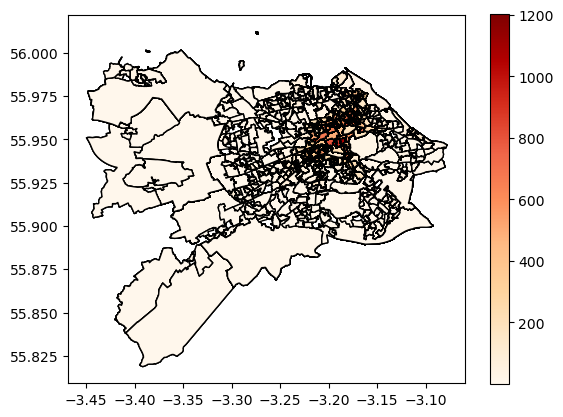

In [32]:
datazone_airbnb_density.plot(column="Density", cmap="OrRd", edgecolor="k", legend=True)

#### Classification by quantiles

`Quantiles` will create attractive maps that place an equal number of observations in each class: If you have 30 counties and 6 data classes, you’ll have 5 counties in each class. The problem with quantiles is that you can end up with classes that have very different numerical ranges (e.g., 1-4, 4-9, 9-250).

<AxesSubplot: >

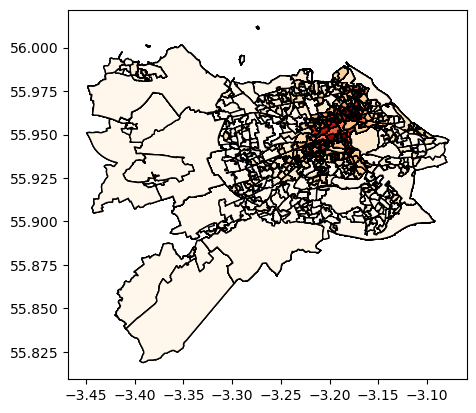

In [33]:
# Splitting the data in four shows some spatial clustering around the center
datazone_airbnb_density.plot(
    column="Density", scheme="quantiles", k=12, cmap="OrRd", edgecolor="k")

#### Classificaton by natural breaks

`Natural Breaks` is a kind of “optimal” classification scheme that finds class breaks that will minimize within-class variance and maximize between-class differences. One drawback of this approach is each dataset generates a unique classification solution, and if you need to make comparison across maps, such as in an atlas or a series (e.g., one map each for 1980, 1990, 2000) you might want to use a single scheme that can be applied across all of the maps.

<AxesSubplot: >

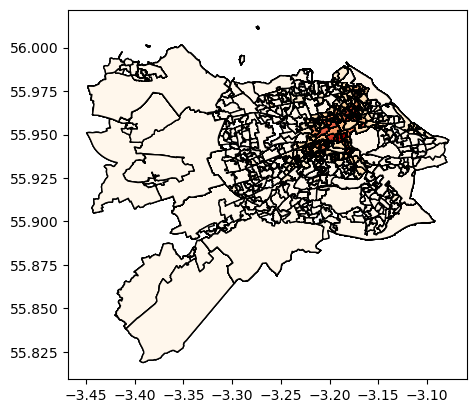

In [34]:
# Compare this to the previous 3-bin figure with quantiles
datazone_airbnb_density.plot(
    column="Density",
    scheme="natural_breaks",
    k=12,
    cmap="OrRd",
    edgecolor="k",
    legend=False,
)

These maps are OK for obtaining a quick overview, but they are very crude and static. Let's add some functionality by harnessing Folium. 

### Interactive Map using Folium

[Folium](https://python-visualization.github.io/folium/latest/) makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.

The library has a number of built-in tilesets from OpenStreetMap, Mapbox, and Stamen, and supports custom tilesets. Folium supports both Image, Video, GeoJSON and TopoJSON overlays and has a number of vector layers built-in.

In [35]:
import folium

In [36]:
# Create a Map instance
m = folium.Map(location=[55.9533, -3.1883], zoom_start=10, control_scale=True)
m

Let's now create a layer for our Edinburgh Airbnb listings : 

In [37]:
edin_airbnb_listings = pd.read_csv('data/edinburgh_airbnb_listings.csv')

In [38]:
# Create a column of empty Point objects
edin_airbnb_listings['geometry'] = [Point() for _ in range(len(edin_listings))]

# Use a lambda function to create Point objects and assign them to the 'point_geometry' column
edin_airbnb_listings['geometry'] = edin_airbnb_listings.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

In [39]:
edin_airbnb_listings = gpd.GeoDataFrame(edin_airbnb_listings, geometry=edin_airbnb_listings['geometry'], crs="WGS84")

In [40]:
edin_airbnb_listings = edin_airbnb_listings[['id', 'neighbourhood', 'latitude', 'longitude', 'geometry']]

In [41]:
edin_airbnb_listings

,id,neighbourhood,latitude,longitude,geometry
0,15420,"Old Town, Princes Street and Leith Street",55.957590,-3.188050,POINT (-3.18805 55.95759)
1,24288,"Canongate, Southside and Dumbiedykes",55.944983,-3.185293,POINT (-3.18529 55.94498)
2,48645,"Canongate, Southside and Dumbiedykes",55.950720,-3.183050,POINT (-3.18305 55.95072)
3,51505,New Town West,55.954800,-3.196410,POINT (-3.19641 55.95480)
4,54188,Dalry and Fountainbridge,55.942170,-3.208630,POINT (-3.20863 55.94217)
...,...,...,...,...,...
8039,974513574116367354,Western Harbour and Leith Docks,55.986759,-3.188275,POINT (-3.18827 55.98676)
8040,974540296775384595,Newington and Dalkeith Road,55.939714,-3.177628,POINT (-3.17763 55.93971)
8041,975083364733576599,Hillside and Calton Hill,55.959688,-3.176968,POINT (-3.17697 55.95969)
8042,976567080851790966,Moredun and Craigour,55.917985,-3.140077,POINT (-3.14008 55.91798)


In [42]:
type(edin_airbnb_listings)

geopandas.geodataframe.GeoDataFrame

### Convert to GeoJSON

The input data used for creating Folium maps generally needs to be in GeoJson format. We can convert our shapefiles (stored as GeoDataFrames) to GeoJSON using `.features.GeoJson`. 

In [43]:
edin_airbnb_listings_gjson = folium.features.GeoJson(edin_airbnb_listings, name='Airbnb listings')

In [44]:
# Check the GeoJSON features
edin_airbnb_listings_gjson.data.get('features')[0]

{'id': '0',
 'type': 'Feature',
 'properties': {'id': 15420,
  'neighbourhood': 'Old Town, Princes Street and Leith Street',
  'latitude': 55.95759,
  'longitude': -3.18805},
 'geometry': {'type': 'Point', 'coordinates': [-3.18805, 55.95759]},
 'bbox': [-3.18805, 55.95759, -3.18805, 55.95759]}

### Heatmap

Now that we have our Airbnb dataset in GeoJson format let's use Folium's mapping capabilitie.

[Folium plugins](https://python-visualization.github.io/folium/plugins.html) allow us to use popular plugins available in leaflet. One of these plugins is [HeatMap](https://python-visualization.github.io/folium/plugins.html#folium.plugins.HeatMap), which creates a heatmap layer from input points.

Let’s visualize a heatmap of the Edinburgh Airbnb listings. HeatMap requires a list of points, or a numpy array as input, so we need to first manipulate the data a bit:

In [45]:
# Get x and y coordinates for each point
edin_airbnb_listings["x"] = edin_airbnb_listings["geometry"].apply(lambda geom: geom.x)
edin_airbnb_listings["y"] = edin_airbnb_listings["geometry"].apply(lambda geom: geom.y)

# Create a list of coordinate pairs
listings = list(zip(edin_airbnb_listings["y"], edin_airbnb_listings["x"]))

In [46]:
from folium.plugins import HeatMap

# Create a Map instance
m = folium.Map(location=[55.953251, -3.188267], tiles='stamentoner', zoom_start=13, control_scale=True)

# Add heatmap to map instance
# Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
HeatMap(listings).add_to(m)

# Alternative syntax:
#m.add_child(HeatMap(points_array, radius=15))

# Show map
m

The red areas show the areas with a high concentration of Airbnb listings.

### Save our heatmap to html for sharing

In [47]:
edinburgh_airbnb_heatmap = "output/edinburgh_airbnb_heatmap.html"
m.save(edinburgh_airbnb_heatmap)

### Choropleth map

Next, let’s check how we can overlay our `datazone` or *tract* map on top of a basemap using Folium’s choropleth method. This method is able to read the geometries and attributes directly from a geodataframe. 

In [48]:
# Create a Geo-id which is needed by the Folium (it needs to have a unique identifier for each row)
datazone_density_tidy['geoid'] = datazone_density_tidy.index.astype(str)

In [49]:
datazone_density_tidy

,DataZone,Name,TotPop2011_x,ResPop2011_x,HHCnt2011_x,StdAreaHa_x,StdAreaKm2,Shape_Leng_x,Shape_Area_x,geometry_x,...,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,Name_x,StdAreaKm2_x,Airbnb_Count,Density,geoid
0,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,0.33,1,237,1,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5,0
1,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,0.08,17,241,2,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5,1
2,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,0.51,2,257,8,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5,2
3,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,1.13,2,272,11,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5,3
4,S01008417,Balerno and Bonnington Village - 01,726,726,299,1029.993186,10.299931,20191.721420,1.029993e+07,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",...,0.08,1,327,0,NaN,Balerno and Bonnington Village - 01,10.299931,5,0.5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8039,S01009010,Queensferry West - 02,1021,1021,404,20.571212,0.205711,2549.606615,2.057121e+05,"POLYGON ((-3.40947 55.98996, -3.40948 55.98955...",...,NaN,1,320,0,NaN,Queensferry West - 02,0.205711,3,14.6,8039
8040,S01009012,Queensferry West - 04,752,752,296,11.924532,0.119244,1694.365106,1.192453e+05,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683...",...,0.49,2,0,14,NaN,Queensferry West - 04,0.119244,2,16.8,8040
8041,S01009012,Queensferry West - 04,752,752,296,11.924532,0.119244,1694.365106,1.192453e+05,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683...",...,1.69,2,37,8,NaN,Queensferry West - 04,0.119244,2,16.8,8041
8042,S01009013,Queensferry West - 05,893,893,363,75.940344,0.759404,5408.285433,7.594034e+05,"POLYGON ((-3.41600 55.99385, -3.41582 55.99347...",...,0.15,2,18,1,NaN,Queensferry West - 05,0.759404,2,2.6,8042


In [50]:
# Select only needed columns
datazone_density_tidy = datazone_density_tidy[['geoid', 'Density', 'geometry_x', 'DataZone', 'Name_x', 'StdAreaKm2_x', 'Airbnb_Count']]

#check data
datazone_density_tidy.head()

,geoid,Density,geometry_x,DataZone,Name_x,StdAreaKm2_x,Airbnb_Count
0,0,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5
1,1,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5
2,2,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5
3,3,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5
4,4,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5


In [51]:
type(datazone_density_tidy)

pandas.core.frame.DataFrame

In [52]:
datazone_density_tidy = gpd.GeoDataFrame(datazone_density_tidy, geometry=datazone_density_tidy['geometry_x'], crs="WGS84")

In [53]:
type(datazone_density_tidy)

geopandas.geodataframe.GeoDataFrame

In [54]:
datazone_density_tidy

,geoid,Density,geometry_x,DataZone,Name_x,StdAreaKm2_x,Airbnb_Count,geometry
0,0,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116..."
1,1,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116..."
2,2,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116..."
3,3,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116..."
4,4,0.5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116...",S01008417,Balerno and Bonnington Village - 01,10.299931,5,"POLYGON ((-3.35779 55.88156, -3.35752 55.88116..."
...,...,...,...,...,...,...,...,...
8039,8039,14.6,"POLYGON ((-3.40947 55.98996, -3.40948 55.98955...",S01009010,Queensferry West - 02,0.205711,3,"POLYGON ((-3.40947 55.98996, -3.40948 55.98955..."
8040,8040,16.8,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683...",S01009012,Queensferry West - 04,0.119244,2,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683..."
8041,8041,16.8,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683...",S01009012,Queensferry West - 04,0.119244,2,"POLYGON ((-3.41584 55.98721, -3.41533 55.98683..."
8042,8042,2.6,"POLYGON ((-3.41600 55.99385, -3.41582 55.99347...",S01009013,Queensferry West - 05,0.759404,2,"POLYGON ((-3.41600 55.99385, -3.41582 55.99347..."


In [55]:
# Select only needed columns
datazone_density_tidy.drop(['geometry_x'],axis=1, inplace=True)

In [56]:
# From review of the GeoJSON output earlier the key is 'properties.geoid'
key_on = 'properties.geoid'  # Adjust this path based on your GeoJSON structure

In [ ]:
# Create a Map instance
m = folium.Map(location=[55.953251, -3.188267], zoom_start=14, control_scale=True)

# Plot a choropleth map
# Notice: 'geoid' column that we created earlier needs to be assigned always as the first column
folium.Choropleth(
    geo_data=datazone_density_tidy.to_json(),
    name='Edinburgh Airbnb listings as at 11 September 2023',
    data=datazone_density_tidy,
    columns=['geoid', 'Density'],
    key_on=key_on,  # Use the correct key path here
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color='white', 
    line_weight=0,
    highlight=False, 
    smooth_factor=1.0,
    threshold_scale=[0, 50, 100, 250, 500, 1000, 1202],
    legend_name= 'Edinburgh Airbnb listings density per datazone as at 11 September 2023 (km2)').add_to(m)

#Show map
m

### Display metadata using Tooltips

It is possible to add different kinds of pop-up messages and tooltips to the map. Here, it would be nice to see the name of datazone and the value of the density metreic when you hover the mouse over the map. Unfortunately this functionality is not apparently implemented in the Choropleth method we used before.

We can add tooltips to our map when plotting the polygons as GeoJson objects using the GeoJsonTooltip feature. (following examples from here and here)

For a quick workaround, we plot the polygons on top of the coropleth map as a transparent layer, and add the tooltip to these objects. 

>Note: this is not an optimal solution as now the polygon geometry get’s stored twice in the output!

In [ ]:
# Convert points to GeoJson
folium.features.GeoJson(datazone_density_tidy,  
                        name='Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip=folium.features.GeoJsonTooltip(fields=['Name_x','StdAreaKm2_x','Airbnb_Count','Density'],
                                                                aliases = ['Datazone','Area{km2)', '# Airbnb listings', 'Density'],
                                                                labels=True,
                                                                sticky=False
                                                                            )
                       ).add_to(m)

m

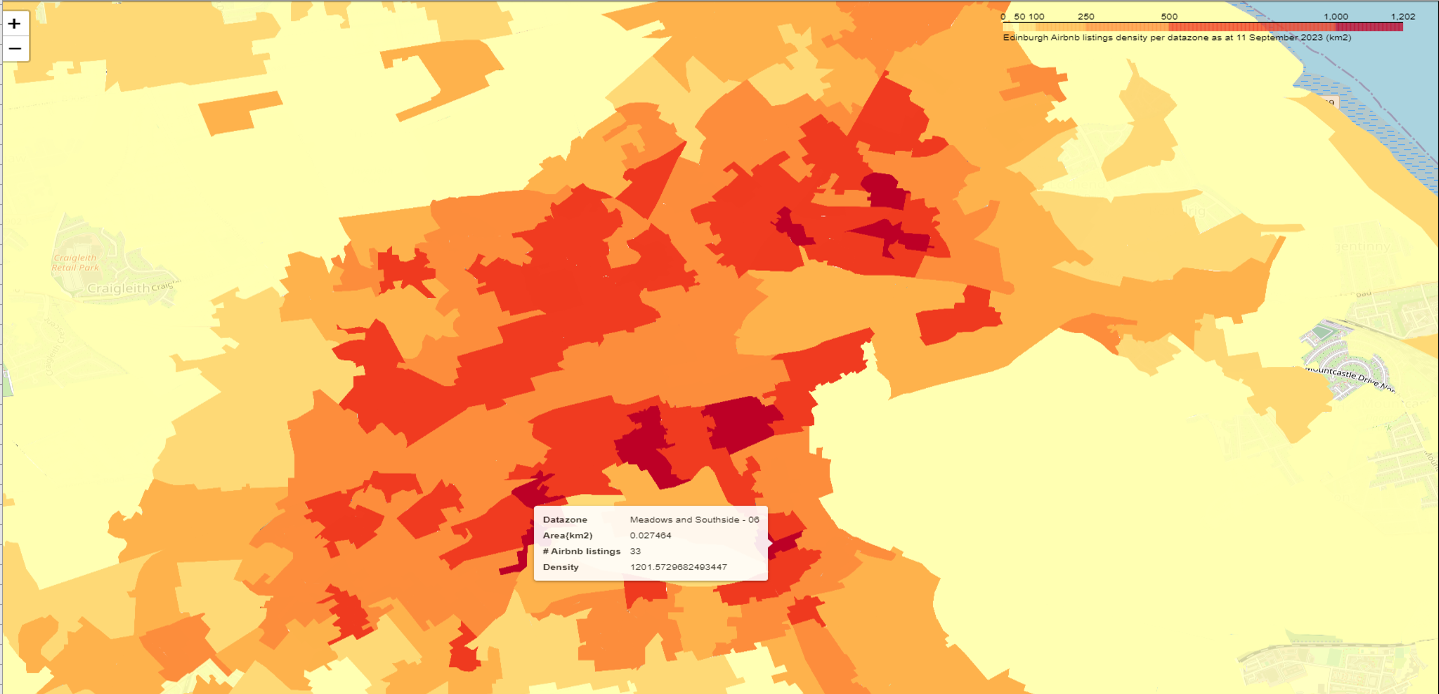

### Save our choropleth map to html for sharing

In [59]:
edinburgh_airbnb = "output/edinburgh_airbnb_choropleth_map.html"
m.save(edinburgh_airbnb)

### Key Takeaways/Insights

This was a very rewarding project. I was able to enrich the granularity of the Inside Airbnb data (which categorized the property listings by 'Neighbourhood') to `data zone` level, which are a bit like tracts. By carrying out a spatial join I was able to locate which datazones (Polygons) the listings (Points) fell within.

The overall density index for Edinburgh Airbnb listings is 32.7 per km2 (8,044 listings covering an area of 245.9 km2). However, this does not tell the whole story. The top five data zones with the highest density of Airbnb listings are:

- Meadows and Southside - 06	`1201.6`
- Hillside and Calton Hill - 07	`1201.1`
- Tollcross - 04	`1147.1`
- Tollcross - 06	`1082.1`
- Old Town, Princes Street and Leith Street - 06	`1077.0`

It was also a good opportunity to make use of Folium which is a powerful and versatile, interactive mapping option.